In [1]:
import torch
import torch.nn as nn
import tiktoken
from chapter4 import GPTModel

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716,  2018, 44808, 18415, 44949, 42175, 39141,
         24002,  8617, 38769, 50013, 43976, 34796,  5987, 11250, 37495, 44278,
         46700,  7098,  1360, 41217, 46771, 21229,  2370,  9335, 21979, 29147,
         33362, 14366, 42812,  3492]])
Output length: 34
Decoded text: Hello, I am connect00007UCTalamigrate Turing Fut provisionsigrateduvian Dos bowlsessorconfigjavascript consonFILrazilgy Twice paperback squeeze evidence maskCat Cruise hospitality peoples cassette ready


### Task

Load the model and optimizer in a new Python session or Jupyter notebook file and continue pretraining it for one more epoch using the train_model_simple function

In [2]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # was previously 1024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Li

In [4]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0., top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        # getting the predictions
        with torch.no_grad():
            logits=model(idx_cond)

        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        # taking only the last logits since that's what we want!
        logits = logits[:, -1, :]

        # filtering logits with top_k sampling:
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float('-inf')).to(logits.device),
                other=logits
            )
        
        # applying temperature scaling
        if temperature > 0:
            logits = logits / temperature
            probabilities = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probabilities, num_samples=1)
        
        # applying greedy next-token generation
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [5]:
# utility functions for text to token ID and vice versa conversions
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adding batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flatten = token_ids.squeeze(0) # removing batch dimension
    return tokenizer.decode(flatten.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

# starting text gets fed to text_to_token_ids for encoding, and that gets fed to generate_text_simple to
# generate the remaining tokens
token_ids = generate(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

decoded_and_generated = token_ids_to_text(token_ids, tokenizer)

print(f"Token IDs for the inputted text (i.e. 'start_context'):\n{text_to_token_ids(start_context, tokenizer)}\n\nGenerated token IDs based on the inputted text and context length:\n{token_ids}\n\nOutput text via decoding the generated token IDs:\n{decoded_and_generated}")

Token IDs for the inputted text (i.e. 'start_context'):
tensor([[6109, 3626, 6100,  345]])

Generated token IDs based on the inputted text and context length:
tensor([[ 6109,  3626,  6100,   345,   760,   284,   670,   319,   438, 15464,
            11,   355,   340,   547]])

Output text via decoding the generated token IDs:
Every effort moves you know to work on--forming, as it were


In [6]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(len(train_data), len(val_data))
print((len(train_data) + len(val_data)) - len(text_data))

18431 2048
0


In [7]:
from chapter2 import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0    
)

In [8]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("----------------------------------\n\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
----------------------------------

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [9]:
import torch.nn.functional as F

# this computes the loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

# this calculates the loss across all the batches in a given data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0 # starting point
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterates over all batches if no fixed num_batches specified
    else:
        # if num_batches > len(data_loader), reduce the num_batches to match len(data_loader) so that it still works
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # averaging the loss over all the batches

In [10]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 0.9526826739311218
Validation loss: 6.2875776290893555


In [11]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # disabling dropout for stable reproducible results
    with torch.no_grad(): # disables gradient tracking since this is eval
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

# ============= model training function ↓ ===============

def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # epoch loop
    for epoch in range(num_epochs):
        model.train()

        # batch loop
        for input_batch, target_batch in train_loader:
            # zero grad
            optimizer.zero_grad()
            
            # loss calculation on current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # backprop to calculate loss gradients
            loss.backward()

            # update the weights based on these loss gradients
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # evaluation (prints the things that happen one-by-one during the training)
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"""Ep {epoch+1} (Step {global_step:06d}): 
                      Train loss {train_loss:.3f}, 
                      Val loss {val_loss:.3f}""")
            
            # printing a sample text after each token
            generate_and_print_sample(
                model, tokenizer, device, start_context
            )
    return train_losses, val_losses, track_tokens_seen

In [15]:
torch.manual_seed(123)

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()
num_epochs=1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context="It is a privilege", tokenizer=tokenizer
)

Ep 1 (Step 000000): 
                      Train loss 0.705, 
                      Val loss 6.363
It is a privilege, one of my surprise, one of the deep arm-chairs forward. "There: make yourself comfortable--and here are the cigars you like."  "Oh, he had dropped his painting, the donkey. "strongest," she began
It is a privilege, that mighty up-stream stroke. The mere outline of the frame called up all Gisburn's past!  "Oh, a smile behind his close grayish beard--as if he had the donkey. "There were days when I
It is a privilege, that mighty up-stream stroke. The mere outline of the tips of a self-confident moustache, I felt to see a degree he had the window-curtains, I saw that, my eye fell on a small picture
It is a privilege, that mighty up-stream stroke. The mere outline of the tips of a self-confident moustache, I felt to see a degree he had the window-curtains, as I turned, my eye fell on a small picture
It is a privilege, I meant to do the picture for nothing--I told Mrs. Strou

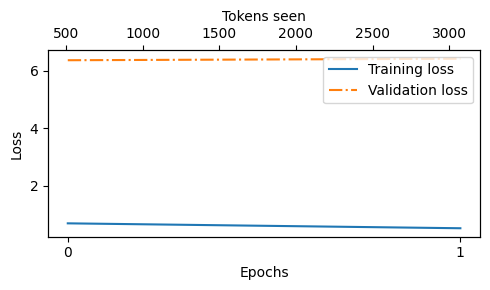

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss" )
    
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

**Not much change here.**